# Model Training Notebook

In [9]:
# ======================================================================
# PROJECT BOOTSTRAP TEMPLATE
# ======================================================================

# --- 1. IMPORTS & CONFIGURATION ---
import os
import re
import time
import pickle
import json
import glob
from pathlib import Path
from IPython.display import display
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, accuracy_score
)
from sklearn.calibration import calibration_curve

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import optuna

# --- Warnings & Logging ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ======================================================================
# 2. DIRECTORY SETUP
# ======================================================================

# Reports directories (figures & best model)
reports_figures = Path('../../../reports/modeling/figures')
reports_best_model = Path('../../../reports/modeling/best_model')

# Artifacts directory
artifacts_path = Path('../../../artifacts')

# --- Create directories only if they don't exist ---
for path in [reports_figures, reports_best_model, artifacts_path]:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created directory: {path.resolve()}")
    else:
        print(f"Directory already exists: {path.resolve()}")

# ======================================================================
# 3. DATA LOADING
# ======================================================================

# Project root and raw data directory (can be overridden by env variables)
PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', '../../')).resolve()
DATA_RAW_DIR = Path(os.environ.get('DATA_RAW_DIR', PROJECT_ROOT / 'data/raw')).resolve()

# Dataset file path
data_file = DATA_RAW_DIR / 'heart disease.parquet'

# --- Robust file loading ---
if not data_file.is_file():
    raise FileNotFoundError(f"Data file not found: {data_file.resolve()}")

# Load dataset
df = pd.read_parquet(data_file)

# Optional: drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Quick check
print(f"Dataset shape: {df.shape}")
display(df.head())

Directory already exists: P:\projects\reports\modeling\figures
Directory already exists: P:\projects\reports\modeling\best_model
Directory already exists: P:\projects\artifacts
Dataset shape: (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
# Paths
processed_data_path = Path('../../data/processed/processed_data.parquet')
artifacts_path = Path('../../artifacts')
artifacts_path.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(processed_data_path)

# Drop unwanted columns
drop_cols = ['Unified_Risk_Score', 'Pred_Prob', 'Pred_Risk_Quantile']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Explicit feature definitions
numerical_features = ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI',
                      'Pulse_Pressure', 'Demographics_Score',
                      'Clinical_Biomarkers_Score', 'Lifestyle_Score']

ordinal_features = ['Glucose_Level', 'Cholesterol_Level', 'BP_level']
ordinal_categories = [
    ['Normal', 'Above Normal', 'Well Above Normal'],   # Glucose_Level
    ['Normal', 'Above Normal', 'Well Above Normal'],   # Cholesterol_Level
    [1, 2, 3, 4, 5]                                   # BP_level numeric codes
]

nominal_features = ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

# Features & target
X = df[numerical_features + ordinal_features + nominal_features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

# Save train/test datasets
train_df = X_train.copy()
train_df['target'] = y_train
test_df = X_test.copy()
test_df['target'] = y_test
train_df.to_parquet(artifacts_path / 'train.parquet', index=False)
test_df.to_parquet(artifacts_path / 'test.parquet', index=False)

# ColumnTransformer with RobustScaler and explicit encoders
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numerical_features),
    ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features)
], remainder='drop')

print("Preprocessing setup complete:")
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)
print("Nominal features:", nominal_features)

Preprocessing setup complete:
Numerical features: ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure', 'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
Ordinal features: ['Glucose_Level', 'Cholesterol_Level', 'BP_level']
Nominal features: ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']


In [11]:
# --------------------------- Paths ---------------------------
PROJECT_ROOT = Path.cwd().parent.parent
best_model_dir = PROJECT_ROOT / 'reports' / 'modeling' / 'best_model'
best_model_dir.mkdir(parents=True, exist_ok=True)

model_path = best_model_dir / 'model.pkl'
summary_path = best_model_dir / 'summary.parquet'
params_path = best_model_dir / 'best_params.json'

# --------------------------- Balancer ---------------------------
from imblearn.over_sampling import SMOTE, RandomOverSampler
BALANCERS = {
    "none": None,
    "smote": SMOTE(random_state=42),
    "ros": RandomOverSampler(random_state=42)
}
best_balancer_name = "smote"   # <-- replace with Optuna-selected balancer
best_balancer_obj = BALANCERS[best_balancer_name]

# --------------------------- Candidate Pipelines ---------------------------
pipelines = {}

# LightGBM
steps_lgbm = [('preprocessor', preprocessor)]
if best_balancer_obj is not None:
    steps_lgbm.append(('balancer', best_balancer_obj))
steps_lgbm.append(('classifier', LGBMClassifier(
    random_state=42, n_jobs=-1, verbose=-1, class_weight='balanced'
)))
pipelines['LGBM'] = ImbPipeline(steps_lgbm)

# XGBoost
steps_xgb = [('preprocessor', preprocessor)]
if best_balancer_obj is not None:
    steps_xgb.append(('balancer', best_balancer_obj))
steps_xgb.append(('classifier', XGBClassifier(
    random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'
)))
pipelines['XGB'] = ImbPipeline(steps_xgb)

# --------------------------- Train & Select Best ---------------------------
best_model_name, best_pipeline, best_score, best_report, best_cm, best_params_dict = None, None, -1, None, None, None

for model_name, pipeline in pipelines.items():
    print(f"\n--- Training {model_name} with {best_balancer_name} ---")
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(
        y_test, y_pred,
        target_names=['No Heart Disease', 'Heart Disease'],
        output_dict=True
    )
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n--- {model_name} Performance ---")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease']))
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=['Actual No HD', 'Actual HD'],
                          columns=['Predicted No HD', 'Predicted HD']))

    # Track best
    if roc_auc > best_score:
        best_score = roc_auc
        best_model_name = model_name
        best_pipeline = pipeline
        best_report = class_report
        best_cm = cm
        # Save hyperparameters of classifier and balancer
        classifier_obj = pipeline.named_steps['classifier']
        best_params_dict = {
            "model_name": model_name,
            "balancer": best_balancer_name,
            "classifier_params": classifier_obj.get_params()
        }

# --------------------------- Save Only Best Model ---------------------------
if best_pipeline is not None:
    with open(model_path, 'wb') as f:
        pickle.dump(best_pipeline, f)
    print(f"\n[SAVED] Best model ({best_model_name}) saved at {model_path.resolve()}")

    # Save summary
    summary_dict = {
        "Metric": [
            "ROC AUC",
            "Accuracy",
            "Precision (No Heart Disease)",
            "Recall (No Heart Disease)",
            "F1-Score (No Heart Disease)",
            "Precision (Heart Disease)",
            "Recall (Heart Disease)",
            "F1-Score (Heart Disease)"
        ],
        "Value": [
            best_score,
            best_report['accuracy'],
            best_report['No Heart Disease']['precision'],
            best_report['No Heart Disease']['recall'],
            best_report['No Heart Disease']['f1-score'],
            best_report['Heart Disease']['precision'],
            best_report['Heart Disease']['recall'],
            best_report['Heart Disease']['f1-score']
        ]
    }
    summary_df = pd.DataFrame(summary_dict)
    summary_df.to_parquet(summary_path, index=False)
    print(f"[SAVED] Summary metrics saved at {summary_path.resolve()}")

    # Save best parameters
    with open(params_path, 'w') as f:
        json.dump(best_params_dict, f, indent=4)
    print(f"[SAVED] Best model parameters saved at {params_path.resolve()}")



--- Training LGBM with smote ---

--- LGBM Performance ---
ROC AUC: 0.7998
                  precision    recall  f1-score   support

No Heart Disease       0.72      0.77      0.74     10501
   Heart Disease       0.75      0.70      0.72     10492

        accuracy                           0.73     20993
       macro avg       0.74      0.73      0.73     20993
    weighted avg       0.74      0.73      0.73     20993

Confusion Matrix:
              Predicted No HD  Predicted HD
Actual No HD             8086          2415
Actual HD                3158          7334

--- Training XGB with smote ---

--- XGB Performance ---
ROC AUC: 0.7941
                  precision    recall  f1-score   support

No Heart Disease       0.71      0.77      0.74     10501
   Heart Disease       0.75      0.69      0.72     10492

        accuracy                           0.73     20993
       macro avg       0.73      0.73      0.73     20993
    weighted avg       0.73      0.73      0.73     20993

In [12]:
print("\n--- Training final model with best parameters and balancer... ---")

# --------------------------- Paths ---------------------------
PROJECT_ROOT = Path.cwd().parent.parent
best_model_dir = PROJECT_ROOT / 'reports' / 'modeling' / 'best_model'

# Do not create a new folder if it exists, but ensure it exists
best_model_dir.mkdir(parents=True, exist_ok=True)

model_path = best_model_dir / 'model.pkl'
summary_path = best_model_dir / 'summary.parquet'
params_path = best_model_dir / 'best_params.json'

# --------------------------- Prepare Pipeline ---------------------------
best_balancer_obj = BALANCERS.get(best_balancer_name, None)

# Remove conflicting keys from classifier_params
conflict_keys = ['random_state', 'class_weight', 'verbose', 'n_jobs', 'balancer', 'objective']
lgbm_params = {k: v for k, v in best_params_dict['classifier_params'].items() if k not in conflict_keys}

steps = [('preprocessor', preprocessor)]
if best_balancer_obj is not None:
    steps.append(('balancer', best_balancer_obj))
steps.append(('classifier', LGBMClassifier(
    **lgbm_params,
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    class_weight='balanced'
)))
final_pipeline = ImbPipeline(steps)

# --------------------------- Fit Pipeline ---------------------------
final_pipeline.fit(X_train, y_train)
print("Final model trained successfully.")

# --------------------------- Save Model (overwrite if exists) ---------------------------
with open(model_path, 'wb') as f:
    pickle.dump(final_pipeline, f)
print(f"Best model saved as pickle at: {model_path.resolve()}")

# --------------------------- Evaluate on Test Set ---------------------------
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

if not np.all(np.isfinite(y_pred_proba)):
    raise ValueError("Non-finite probabilities in test predictions.")

roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(
    y_test, y_pred,
    target_names=['No Heart Disease', 'Heart Disease'],
    output_dict=True
)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual No HD', 'Actual HD'], columns=['Predicted No HD', 'Predicted HD'])

print("\n--- Model Performance on Test Set ---")
print(f"Test ROC AUC: {roc_auc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease']))

# Safe display for both notebook and script
try:
    from IPython.display import display
    display(cm_df)
except ImportError:
    print("\nConfusion Matrix (Test):")
    print(cm_df)

# --------------------------- Save Summary Metrics (overwrite if exists) ---------------------------
# Remove old markdown files if any
for md_file in glob.glob(str(best_model_dir / '*.md')):
    try:
        os.remove(md_file)
    except Exception as e:
        print(f"Could not remove {md_file}: {e}")

summary_dict = {
    "Metric": [
        "ROC AUC",
        "Accuracy",
        "Precision (No Heart Disease)",
        "Recall (No Heart Disease)",
        "F1-Score (No Heart Disease)",
        "Precision (Heart Disease)",
        "Recall (Heart Disease)",
        "F1-Score (Heart Disease)"
    ],
    "Value": [
        roc_auc,
        class_report['accuracy'],
        class_report['No Heart Disease']['precision'],
        class_report['No Heart Disease']['recall'],
        class_report['No Heart Disease']['f1-score'],
        class_report['Heart Disease']['precision'],
        class_report['Heart Disease']['recall'],
        class_report['Heart Disease']['f1-score']
    ]
}
summary_df = pd.DataFrame(summary_dict)
summary_df.to_parquet(summary_path, index=False)
print(f"Summary of evaluation metrics saved at: {summary_path.resolve()}")

# --------------------------- Save Best Parameters & Preprocessing (overwrite if exists) ---------------------------
best_params_dict = {
    "classifier_params": lgbm_params,
    "balancer": best_balancer_name,
    "preprocessor": {
        "numerical_features": numerical_features,
        "ordinal_features": ordinal_features,
        "ordinal_categories": ordinal_categories,
        "nominal_features": nominal_features
    }
}

with open(params_path, 'w') as f:
    json.dump(best_params_dict, f, indent=4)
print(f"Best model parameters & preprocessing saved at: {params_path.resolve()}")


--- Training final model with best parameters and balancer... ---
Final model trained successfully.
Best model saved as pickle at: P:\projects\heart disease prediction\reports\modeling\best_model\model.pkl

--- Model Performance on Test Set ---
Test ROC AUC: 0.7998

Classification Report (Test):
                  precision    recall  f1-score   support

No Heart Disease       0.72      0.77      0.74     10501
   Heart Disease       0.75      0.70      0.72     10492

        accuracy                           0.73     20993
       macro avg       0.74      0.73      0.73     20993
    weighted avg       0.74      0.73      0.73     20993



,Predicted No HD,Predicted HD
Actual No HD,8086,2415
Actual HD,3158,7334


Summary of evaluation metrics saved at: P:\projects\heart disease prediction\reports\modeling\best_model\summary.parquet
Best model parameters & preprocessing saved at: P:\projects\heart disease prediction\reports\modeling\best_model\best_params.json


Test Accuracy: 0.7345


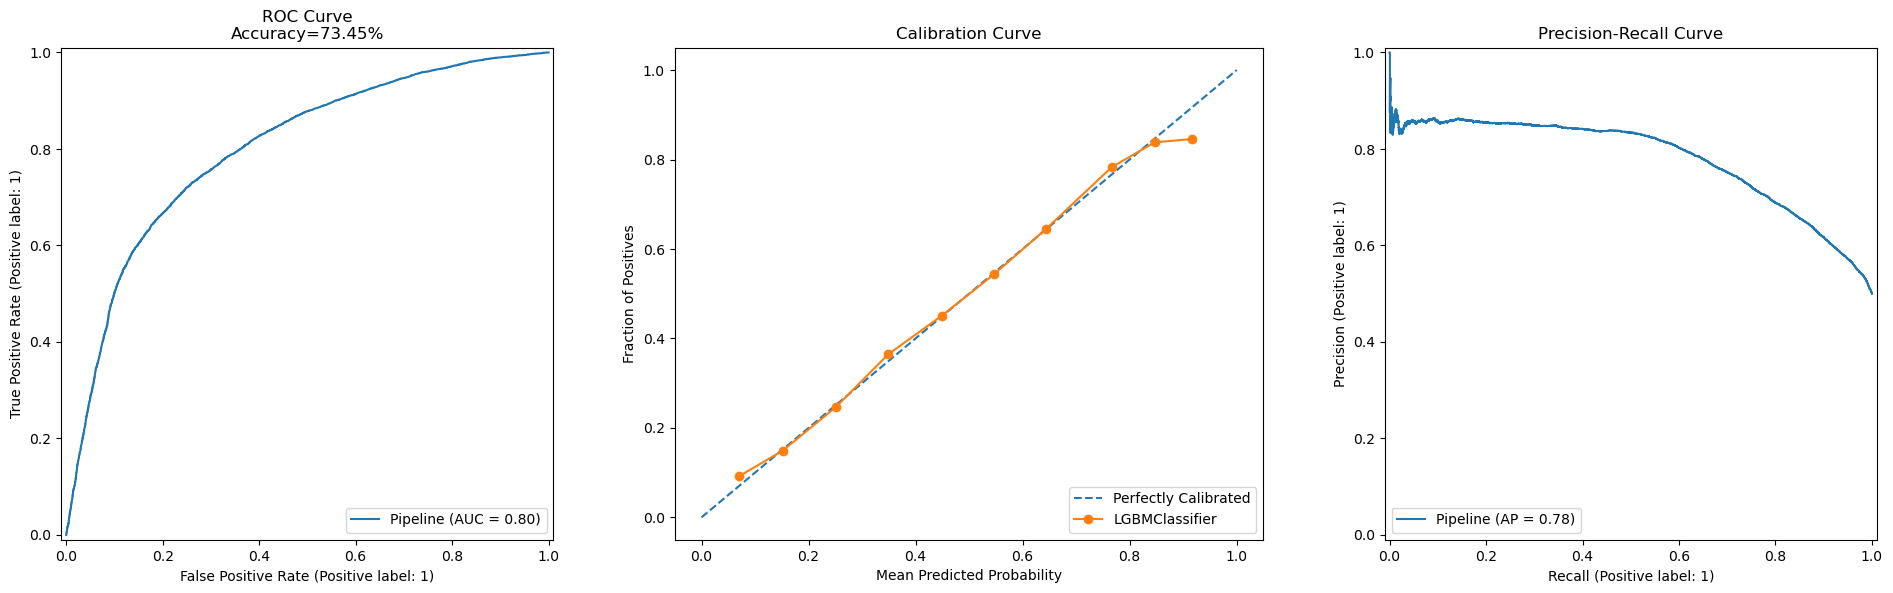

[SUCCESS] Model metrics plots saved at: P:\projects\heart disease prediction\reports\modeling\figures\01_Model_Metrics.png


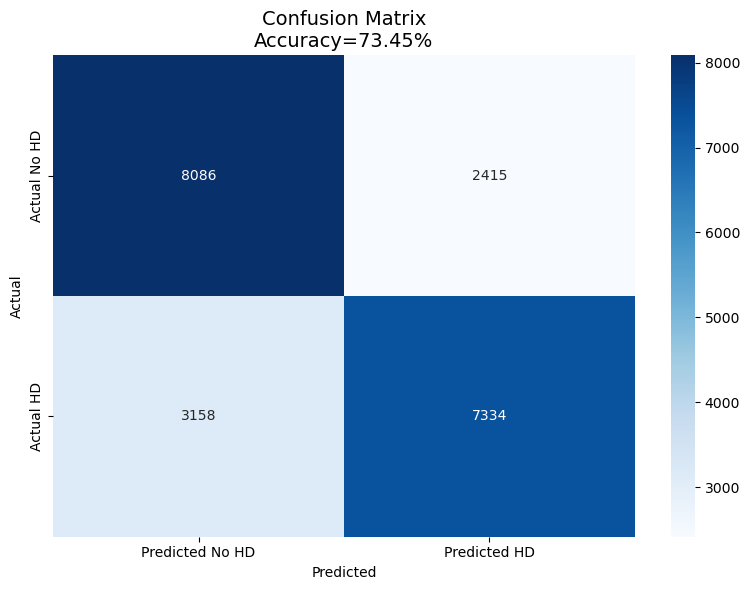

[SUCCESS] Confusion matrix plot saved at: P:\projects\heart disease prediction\reports\modeling\figures\02_Confusion_Matrix.png


In [13]:
# --------------------------- Compute Accuracy ---------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# --------------------------- Paths ---------------------------
PROJECT_ROOT = Path.cwd().parent.parent  # two levels up from src/notebooks
FIG_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'figures'

# Ensure folder exists, do not create new if already present
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------- Helper Function ---------------------------
def sanitize_filename(title):
    return re.sub(r'[^\w\-_\. ]', '_', title).replace(' ', '_')

# --------------------------- Plot ROC, Calibration, Precision-Recall ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. ROC Curve
try:
    RocCurveDisplay.from_estimator(final_pipeline, X_test, y_test, ax=axes[0])
    axes[0].set_title(f'ROC Curve\nAccuracy={accuracy:.2%}', fontsize=12)
except Exception as e:
    print(f"ROC Curve error: {e}")

# 2. Calibration Curve
try:
    if np.all(np.isfinite(y_pred_proba)):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
        axes[1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
        axes[1].plot(mean_predicted_value, fraction_of_positives, marker='o', label='LGBMClassifier')
        axes[1].set_xlabel('Mean Predicted Probability')
        axes[1].set_ylabel('Fraction of Positives')
        axes[1].set_title('Calibration Curve', fontsize=12)
        axes[1].legend(loc='lower right')
    else:
        raise ValueError("Non-finite predicted probabilities for calibration curve.")
except Exception as e:
    print(f"Calibration Curve error: {e}")

# 3. Precision-Recall Curve
try:
    PrecisionRecallDisplay.from_estimator(final_pipeline, X_test, y_test, ax=axes[2])
    axes[2].set_title('Precision-Recall Curve', fontsize=12)
except Exception as e:
    print(f"Precision-Recall Curve error: {e}")

plt.tight_layout()

# --------------------------- Save Plots ---------------------------
roc_file = FIG_DIR / sanitize_filename('01_Model_Metrics.png')
plt.savefig(roc_file, dpi=150, bbox_inches='tight')  # overwrite if exists
plt.show()
print(f"[SUCCESS] Model metrics plots saved at: {roc_file.resolve()}")

# --------------------------- Confusion Matrix Heatmap ---------------------------
cm_file = FIG_DIR / sanitize_filename('02_Confusion_Matrix.png')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No HD', 'Predicted HD'],
            yticklabels=['Actual No HD', 'Actual HD'])
plt.title(f'Confusion Matrix\nAccuracy={accuracy:.2%}', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(cm_file, dpi=150, bbox_inches='tight')  # overwrite if exists
plt.show()
print(f"[SUCCESS] Confusion matrix plot saved at: {cm_file.resolve()}")


--- Generating SHAP Summary (Swarm) Plot ---


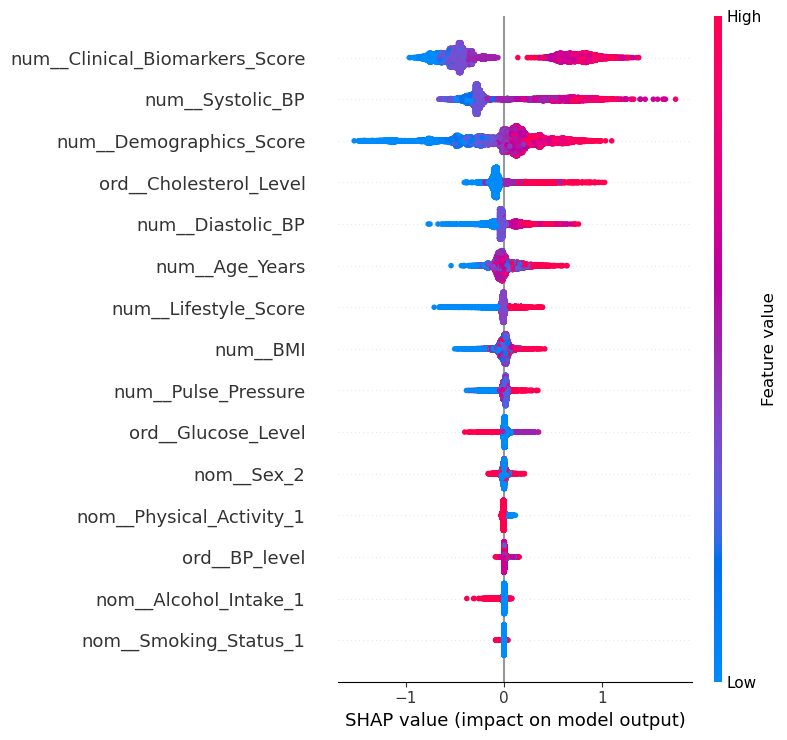

[SUCCESS] SHAP swarm plot saved at: P:\projects\heart disease prediction\reports\modeling\figures\03_SHAP_Swarm_Plot.png


In [14]:
# ==============================================================================
# 6. SHAP SUMMARY SWARM PLOT
# ==============================================================================
print("\n--- Generating SHAP Summary (Swarm) Plot ---")

# --------------------------- Prepare Data ---------------------------
X_test_processed = preprocessor.transform(X_test)

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names_out = list(preprocessor.get_feature_names_out())
else:
    feature_names_out = list(X_test.columns)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names_out)

# --------------------------- SHAP Explainer ---------------------------
try:
    lgbm_model = final_pipeline.named_steps['classifier']
    explainer = shap.TreeExplainer(lgbm_model)
    shap_values = explainer.shap_values(X_test_processed)

    # For binary classification, select class 1
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]

    # --------------------------- Swarm Plot ---------------------------
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=False)

    # --------------------------- Paths ---------------------------
    PROJECT_ROOT = Path.cwd().parent.parent  # two levels up from src/notebooks
    SHAP_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'figures'
    SHAP_DIR.mkdir(parents=True, exist_ok=True)  # do not create new if exists

    # Helper to sanitize filename
    def sanitize_filename(title):
        return re.sub(r'[^\w\-_\. ]', '_', title).replace(' ', '_')

    img_path = SHAP_DIR / sanitize_filename('03_SHAP_Swarm_Plot.png')
    plt.tight_layout()
    plt.savefig(img_path, dpi=150, bbox_inches='tight')  # overwrite if exists
    plt.show()
    print(f"[SUCCESS] SHAP swarm plot saved at: {img_path.resolve()}")

except Exception as e:
    print(f"SHAP swarm plot error: {e}")


--- SHAP Dependence Plots: Feature vs SHAP Value (Top 6 Features) ---


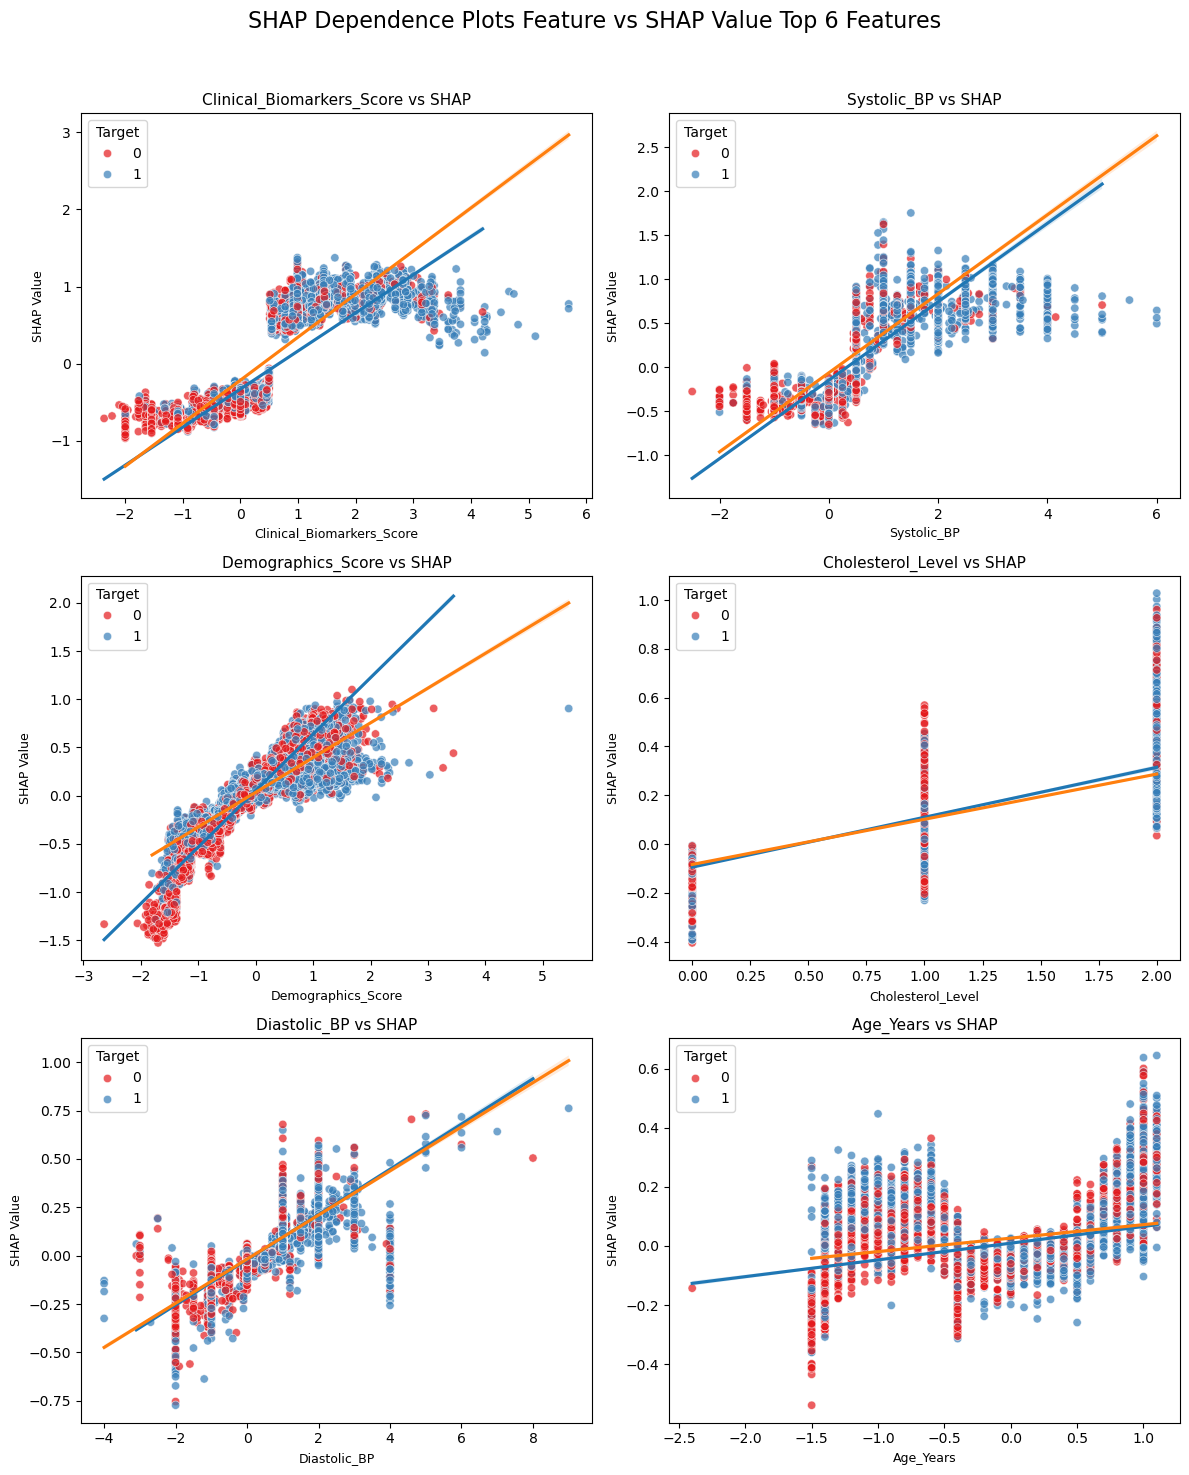

[SUCCESS] SHAP dependence plots saved at: P:\projects\heart disease prediction\reports\modeling\figures\04_SHAP_Dependence_Plots_Feature_vs_SHAP_Value_Top_6_Features.png


In [15]:
# ==============================================================================
# 6. SHAP EXPLAINABILITY (Dependence Plots)
# ==============================================================================
print("\n--- SHAP Dependence Plots: Feature vs SHAP Value (Top 6 Features) ---")

# --------------------------- Prepare Data ---------------------------
X_test_processed = preprocessor.transform(X_test)
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names_out = list(preprocessor.get_feature_names_out())
else:
    feature_names_out = list(X_test.columns)

lgbm_model = final_pipeline.named_steps['classifier']

# Compute SHAP values
try:
    explainer = shap.TreeExplainer(lgbm_model)
    shap_summary_values = explainer.shap_values(X_test_processed)
    if isinstance(shap_summary_values, list) and len(shap_summary_values) == 2:
        shap_summary_values = shap_summary_values[1]
except Exception as e:
    print(f"SHAP computation error: {e}")
    shap_summary_values = None

# --------------------------- Plot Top 6 Features ---------------------------
dependence_title = 'SHAP Dependence Plots Feature vs SHAP Value Top 6 Features'

try:
    if (
        shap_summary_values is not None
        and shap_summary_values.shape[1] > 0
        and shap_summary_values.size > 0
        and np.all(np.isfinite(shap_summary_values))
        and not np.all(shap_summary_values == 0)
    ):
        shap_abs_mean = np.abs(shap_summary_values).mean(axis=0)
        n_features_to_plot = min(6, shap_summary_values.shape[1])
        top_idx = np.argsort(shap_abs_mean)[-n_features_to_plot:][::-1]
        top_features = [feature_names_out[i] for i in top_idx]
        target_for_plot = y_test.reset_index(drop=True)
        X_test_df = pd.DataFrame(X_test_processed, columns=feature_names_out)

        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
        axes = axes.flatten()

        for i, feature in enumerate(top_features):
            ax = axes[i]
            feature_idx = feature_names_out.index(feature)
            x = X_test_df[feature]
            sns.scatterplot(
                x=x,
                y=shap_summary_values[:, feature_idx],
                hue=target_for_plot,
                palette='Set1',
                ax=ax,
                alpha=0.7
            )
            for tval in sorted(target_for_plot.unique()):
                mask = target_for_plot == tval
                sns.regplot(
                    x=x[mask],
                    y=shap_summary_values[mask, feature_idx],
                    ax=ax,
                    scatter=False,
                    ci=95
                )
            ax.set_title(f'{feature.split("__")[-1]} vs SHAP', fontsize=11)
            ax.set_xlabel(feature.split("__")[-1], fontsize=9)
            ax.set_ylabel("SHAP Value", fontsize=9)
            ax.legend(title='Target')

        # Remove unused axes
        for j in range(n_features_to_plot, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(dependence_title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # --------------------------- Save Figure ---------------------------
        PROJECT_ROOT = Path.cwd().parent.parent
        SHAP_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'figures'
        SHAP_DIR.mkdir(parents=True, exist_ok=True)  # do not create new if exists

        def sanitize_filename(title):
            return re.sub(r'[^\w\-_\. ]', '_', title).replace(' ', '_')

        save_path = SHAP_DIR / ('04_' + sanitize_filename(dependence_title) + '.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')  # overwrite if exists
        plt.show()
        print(f"[SUCCESS] SHAP dependence plots saved at: {save_path.resolve()}")

    else:
        print("SHAP summary values are not valid for dependence plots.")

except Exception as e:
    print(f"SHAP dependence plot error: {e}")